# Spam classification with LSTM


# Data Loading


In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2022-02-21 06:17:53--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.102, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/adso7bps9f863rbb3bsth190vfi044p5/1645424250000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2022-02-21 06:17:53--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/adso7bps9f863rbb3bsth190vfi044p5/1645424250000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-docs.goog

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [3]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [4]:
train_texts[:10]  # Just checking the examples in train_text

['18 days to Euro2004 kickoff! U will be kept informed of all the latest news and results daily. Unsubscribe send GET EURO STOP to 83222.',
 'great princess! I love giving and receiving oral. Doggy style is my fave position. How about you? I enjoy making love  &lt;#&gt;  times per night :)',
 'A Boy loved a gal. He propsd bt she didnt mind. He gv lv lttrs, Bt her frnds threw thm. Again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal. Wn it was about 2 hit d girl,d boy ran like hell n saved her. She asked \'hw cn u run so fast?\' D boy replied \\Boost is d secret of my energy\\" n instantly d girl shouted \\"our energy\\" n Thy lived happily 2gthr drinking boost evrydy Moral of d story:- I hv free msgs:D;): gud ni8"',
 "Very strange.  and  are watching the 2nd one now but i'm in bed. Sweet dreams, miss u ",
 'Love you aathi..love u lot..',
 "So how's the weather over there?",
 'Yup... How Ì_ noe leh...',
 'Will Ì_ b going to esplanade fr home?',
 '8007 FREE fo

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.





In [5]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2022-02-21 06:17:53--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 74.125.142.139, 74.125.142.113, 74.125.142.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vit05eulfbb1s30k9erj69spb4rkvp12/1645424250000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2022-02-21 06:17:58--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vit05eulfbb1s30k9erj69spb4rkvp12/1645424250000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.195.132|:443

In [6]:
!wget https://campuspro-uploads.s3.us-west-2.amazonaws.com/f14e42f6-0f57-4d3c-bf3c-6eb8982c822b/1447cf92-9ef5-4097-939d-f69337174ded/glove.6B.300d__50k.txt.zip
!unzip glove.6B.300d__50k.txt.zip

--2022-02-21 06:18:02--  https://campuspro-uploads.s3.us-west-2.amazonaws.com/f14e42f6-0f57-4d3c-bf3c-6eb8982c822b/1447cf92-9ef5-4097-939d-f69337174ded/glove.6B.300d__50k.txt.zip
Resolving campuspro-uploads.s3.us-west-2.amazonaws.com (campuspro-uploads.s3.us-west-2.amazonaws.com)... 52.92.162.82
Connecting to campuspro-uploads.s3.us-west-2.amazonaws.com (campuspro-uploads.s3.us-west-2.amazonaws.com)|52.92.162.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49335722 (47M) [application/zip]
Saving to: ‘glove.6B.300d__50k.txt.zip’

glove.6B.300d__50k. 100%[===================>]  47.05M  19.3MB/s    in 2.4s    

2022-02-21 06:18:05 (19.3 MB/s) - ‘glove.6B.300d__50k.txt.zip’ saved [49335722/49335722]

Archive:  glove.6B.300d__50k.txt.zip
replace glove.6B.300d__50k.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: __MACOSX/._glove.6B.300d__50k.txt  


## Load GloVe Embeddings

In [7]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
        print(embedding_ls[-1].size)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

300


## Import packages

In [8]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

     |████████████████████████████████| 895 kB 8.9 MB/s 


# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [9]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

  0%|          | 0/3902 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

In [10]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[521, 251, 6, 1, 12768, 807, 6481, 45, 32, 1292, 3856, 5, 66, 2, 995, 174, 7, 606, 1, 1, 1547, 171, 1538, 839, 6, 1, 4], [355, 4244, 807, 43, 837, 1229, 7, 2748, 1, 1, 1137, 16, 194, 1, 1, 199, 61, 83, 190, 43, 3712, 435, 837, 725, 18811, 91, 2751, 725, 16537, 91, 248, 534, 366, 47, 26], [9, 1608, 4148, 9, 1, 20, 1, 7671, 69, 1, 1, 20, 1, 49032, 1, 3, 7671, 73, 1, 3287, 1, 380, 1970, 1608, 849, 234, 1, 1970, 21757, 3, 39533, 81, 9, 2577, 17, 11340, 1813, 1970, 1, 1, 22, 17, 61, 234, 418, 1970, 1751, 3, 1970, 1608, 1423, 119, 5615, 3816, 4039, 1, 69, 478, 1, 1, 15766, 6481, 309, 102, 1607, 190, 1, 1970, 1608, 5301, 7959, 1939, 16, 1970, 1781, 5, 194, 636, 7959, 1, 3816, 9681, 1970, 1751, 7423, 7959, 1, 164, 636, 7959, 1, 3816, 25004, 1579, 12443, 1, 4146, 1939, 1, 4013, 5, 1970, 525, 47, 13, 43, 1, 417, 1, 47, 1970, 91, 26, 47, 1, 1, 1], [193, 1, 7, 34, 2643, 2, 2768, 50, 116, 36, 43, 1, 8, 1, 3716, 5561, 3, 2216, 6481], [837, 83, 1, 1, 837, 6481, 532, 1]

# Create DataLoaders 
 Now, let's create pytorch DataLoaders for our train, val, and test data.

 `SpamDataset` class is based on torch [`Dataset`](https://pytorch.org/docs/1.7.0/data.html?highlight=dataset#torch.utils.data.Dataset). It has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.

In order to use batch processing, all the examples need to effectively be the same length. We'll do this by adding padding tokens. `spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch. 
- If `self.max_sent_length` is less than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because our input sentences in the batch may be much shorter than `self.max_sent_length`.  

Please check the comment block in the code near TODO for more details.


Example: 

* PAD token id = 0
* max_sent_length = 5

input list of sequences:
```
inp = [
    [1,4,5,3,5,6,7,4,4],
    [3,5,3,2],
    [2,5,3,5,6,7,4],
]
```
then padded minibatch looks like this:
```
padded_input = 
    [[1,4,5,3,5],
     [3,5,3,2,0],
     [2,5,3,5,6]]
```

In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self, batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        # What the input `batch`? That's for you to figure out!
        # You can read the Dataloader documentation, or you can use print
        # function to debug. 
        """ 
        data_list = [] # store padded sequences
        label_list = []
        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          
        """
        for token_idx, label in batch:
            # get current length
            curr_seq_len = len(token_idx)     
            up_token_idx = token_idx + [0] * (self.max_sent_length - curr_seq_len)
            data_list.append(up_token_idx)  
            label_list.append(label)                                                                                           

        data_list = torch.tensor(data_list)
        label_list = torch.tensor(label_list)
        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an batch from train_loader.


In [12]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 128])
data_batch:  tensor([[ 7944, 15114,     3,  ...,     0,     0,     0],
        [  208, 10373,   170,  ...,     0,     0,     0],
        [ 7959, 36104, 15114,  ...,     0,     0,     0],
        ...,
        [ 3204,     1,    43,  ...,     0,     0,     0],
        [   43,  1315,     6,  ...,     0,     0,     0],
        [ 7959,  7944, 15114,  ...,     0,     0,     0]])
labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])


# Build a BiLSTM Classifier 

Now we are going to build a BiLSTM classifier. 

The hyperparameters for LSTM are already given, but they are not necessarily optimal. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

* `__init__`: Class constructor. Here we define layers / parameters of LSTM.
* `forward`: This function is used whenever you call your object as `model()`. It takes the input minibatch and returns the output representation from LSTM.

In [13]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """

    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm = nn.LSTM(input_size=embeddings.shape[1], hidden_size=hidden_size, num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)
        self.non_linearity = nn.ReLU()  # For example, ReLU
        self.clf = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)  # classifier layer
        """
           Define the components of your BiLSTM Classifier model
           
        """

    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 3 Deep Learning
           we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer

    def forward(self, inputs):
        logits = None
        """
           Write forward pass for LSTM. 
        """

        embed_out = self.dropout(self.embedding_layer(inputs))
        lstm_out, (_, _) = self.lstm(embed_out)
        mean_out = torch.mean(lstm_out, dim=1)
        logits = self.clf(self.non_linearity(mean_out))

        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [14]:
def evaluate(model, dataloader, device):
    accuracy = 0
    model.eval()
    """
        
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab 3 part 1.
    """
    model.to(device)
    for batch_data, batch_label in dataloader:
        y_hat = model(batch_data.to(device))
        accuracy += (torch.argmax(y_hat.detach().cpu(), dim=-1) == batch_label).sum() / batch_data.shape[0]
        break

    accuracy = accuracy.item()

    return accuracy

# Initialize the BiLSTM classifier model, criterion and optimizer


In [15]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model with early stopping 

Train the model for `NUM_EPOCHS`. 
Keep track of training loss.  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` number of epochs in a row, stop training. 


In [16]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()  # this enables dropout/regularization
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_history.append(loss.item())
        
    # The end of a training epoch 

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        
    """
    curr_val_accuracy = evaluate(model, val_loader, device)
    val_accuracy_history.append(curr_val_accuracy)

    if curr_val_accuracy > best_val_accuracy:
        best_val_accuracy = curr_val_accuracy
        torch.save(model, 'best_model.pt')
        n_no_improve = 0
    else:
        n_no_improve += 1

        if n_no_improve > early_stop_patience:
            break

print("Best validation accuracy is: ", best_val_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Best validation accuracy is:  1.0


# Draw training curve 
X-axis: training steps, Y-axis: training loss



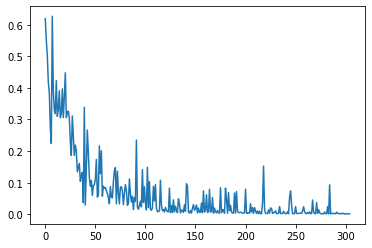

In [17]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

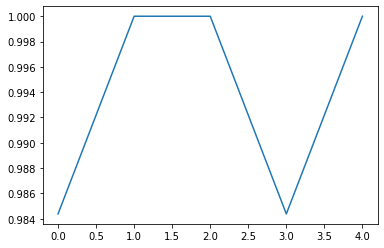

In [18]:
pd.Series(val_accuracy_history).plot()

##  Test Accuracy

In [19]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
print(test_accuracy)

0.96875
